In [1]:
from spectrae import Spectra, SpectraDataset
import pandas as pd
import numpy as np
from tqdm import tqdm

# SPECTRA Deep Mutational Scan Tutorial

### We take an example dataset from ProteinGym, A4_HUMAN_Seuma_2022.csv 
### We define a spectral property where two samples are similar if they share a mutation or not. 
### We define cross-split overlap as the proportion of mutations that are shared between samples in the train and test.

In [2]:
class ProteinGym_Dataset(SpectraDataset):
    
    def parse(self, input_file):
        return pd.read_csv(input_file)['mutant'].unique()
    
    def __len__(self):
        return len(self.samples)
    
    def sample_to_index(self, sample):
        if not hasattr(self, 'index_to_sequence'):
            print("Generating index to sequence")
            self.index_to_sequence = {}
            for i in tqdm(range(len(self))):
                x = self.__getitem__(i)
                self.index_to_sequence[x] = i

        return self.index_to_sequence[sample] 

    def __getitem__(self, idx):
        return self.samples[idx]

In [3]:
class SPECTRA_DMS(Spectra):

    def spectra_properties(self, sample_one, sample_two):
        if sample_one != sample_two:
            for mut in sample_one.split(':'):
                if mut in sample_two:
                    return 1
            return 0
        else:
            return 1

    def cross_split_overlap(self, train, test):

        def flatten(l):
            return [item for sublist in l for item in sublist]

        one = flatten([i.split(':') for i in train])
        two = flatten([i.split(':') for i in test])

        def check_list(list, to_check):
            for i in list:
                if self.spectra_properties(i, to_check):
                    return True
            return False
        
        combined_mutations = list(set(one + two))

        num_overlap = 0
        for i in combined_mutations:
            if check_list(one, i) and check_list(two, i):
                num_overlap += 1
        
        return num_overlap/len(combined_mutations)

In [4]:
PG_Dataset = ProteinGym_Dataset('A4_HUMAN_Seuma_2022.csv', 'A4_HUMAN_Seuma_2022')

In [5]:
pg_spectra = SPECTRA_DMS(PG_Dataset, binary = True)

In [7]:
pg_spectra.pre_calculate_spectra_properties('PGA4Human')

File PGA4Human_precalculated_spectra_properties already exists, set force_recalculate to True to recalculate


In [8]:
spectra_parameters = {'number_repeats': 3, 
                      'random_seed': [42, 44, 46],
                      'spectral_parameters': ["{:.2f}".format(i) for i in np.arange(0, 1.05, 0.05)],
                      'force_reconstruct': True,
                                              }

pg_spectra.generate_spectra_splits(**spectra_parameters)

  0%|          | 0/109675455 [00:00<?, ?it/s]

100%|██████████| 109675455/109675455 [01:52<00:00, 975220.55it/s] 


Stats for SPECTRA property graph (SPG)
Number of nodes: 14268
Number of edges: 2139791
Number of connected components: 1


SPG is not fully connected
Component 0 is not fully connected
Generating SPECTRA split for spectral parameter 0.0 and dataset A4_HUMAN_Seuma_2022
Deleted 0 nodes from the graph since they were connected to all other nodes
Number of samples in independent set: 14268
Train size: 11414	Test size: 2854
Cross split overlap: 0.9565217391304348



Generating SPECTRA split for spectral parameter 0.0 and dataset A4_HUMAN_Seuma_2022
Deleted 0 nodes from the graph since they were connected to all other nodes
Number of samples in independent set: 14268
Train size: 11414	Test size: 2854
Cross split overlap: 0.9644268774703557



Generating SPECTRA split for spectral parameter 0.0 and dataset A4_HUMAN_Seuma_2022
Deleted 0 nodes from the graph since they were connected to all other nodes
Number of samples in independent set: 14268
Train size: 11414	Test size: 2854
Cross split ove

[]

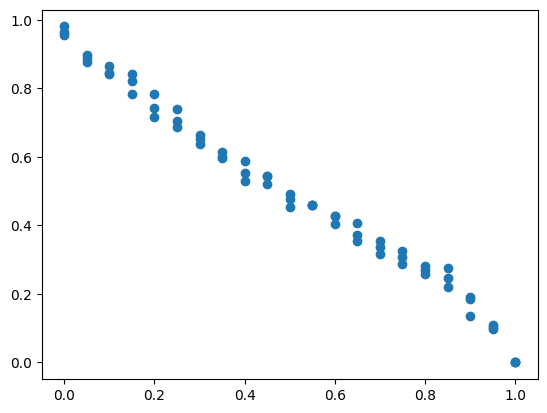

In [9]:
import matplotlib.pyplot as plt
stats = pg_spectra.return_all_split_stats()
plt.scatter(stats['SPECTRA_parameter'], stats['cross_split_overlap'])

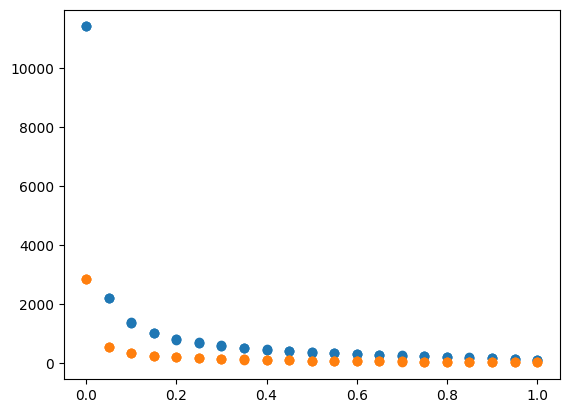

In [10]:
plt.scatter(stats['SPECTRA_parameter'], stats['train_size'])
plt.scatter(stats['SPECTRA_parameter'], stats['test_size']) 